In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/nasa-battery-dataset/cleaned_dataset/metadata.csv
/kaggle/input/nasa-battery-dataset/cleaned_dataset/extra_infos/README_49_50_51_52.txt
/kaggle/input/nasa-battery-dataset/cleaned_dataset/extra_infos/README_45_46_47_48.txt
/kaggle/input/nasa-battery-dataset/cleaned_dataset/extra_infos/README_05_06_07_18.txt
/kaggle/input/nasa-battery-dataset/cleaned_dataset/extra_infos/README_29_30_31_32.txt
/kaggle/input/nasa-battery-dataset/cleaned_dataset/extra_infos/README_25_26_27_28.txt
/kaggle/input/nasa-battery-dataset/cleaned_dataset/extra_infos/README_33_34_36.txt
/kaggle/input/nasa-battery-dataset/cleaned_dataset/extra_infos/README_53_54_55_56.txt
/kaggle/input/nasa-battery-dataset/cleaned_dataset/extra_infos/README_41_42_43_44.txt
/kaggle/input/nasa-battery-dataset/cleaned_dataset/extra_infos/README_38_39_40.txt
/kaggle/input/nasa-battery-dataset/cleaned_dataset/data/02421.csv
/kaggle/input/nasa-battery-dataset/cleaned_dataset/data/04530.csv
/kaggle/input/nasa-battery-dataset/c

In [2]:
# Import libraries
import os
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

import os
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
# Set base paths
DATA_DIR = '/kaggle/input/nasa-battery-dataset/cleaned_dataset'
DATA_PATH = os.path.join(DATA_DIR, 'data')
META_PATH = os.path.join(DATA_DIR, 'metadata.csv')

In [3]:
metadata = pd.read_csv(META_PATH)

# Normalize filenames to 8-digit format with .csv
metadata['filename'] = metadata['filename'].astype(str).str.zfill(8)
if not metadata['filename'].str.endswith('.csv').any():
    metadata['filename'] += '.csv'

# Lowercase column names
metadata.columns = metadata.columns.str.lower()

display(metadata.head())

,type,start_time,ambient_temperature,battery_id,test_id,uid,filename,capacity,re,rct
0,discharge,[2010. 7. 21. 15. 0. ...,4,B0047,0,1,00001.csv,1.6743047446975208,NaN,NaN
1,impedance,[2010. 7. 21. 16. 53. ...,24,B0047,1,2,00002.csv,NaN,0.05605783343888099,0.20097016584458333
2,charge,[2010. 7. 21. 17. 25. ...,4,B0047,2,3,00003.csv,NaN,NaN,NaN
3,impedance,[2010 7 21 20 31 5],24,B0047,3,4,00004.csv,NaN,0.05319185850921101,0.16473399914864734
4,discharge,[2.0100e+03 7.0000e+00 2.1000e+01 2.1000e+01 2...,4,B0047,4,5,00005.csv,1.5243662105099023,NaN,NaN


In [4]:
records = []
missing = 0

# Only valid filenames
valid_files = metadata[metadata['filename'].str.endswith('.csv')].copy()

for _, row in tqdm(valid_files.iterrows(), total=len(valid_files)):
    file = row['filename']
    file_path = os.path.join(DATA_PATH, file)

    if os.path.exists(file_path):
        df = pd.read_csv(file_path)
        df.columns = df.columns.str.lower()

        # Add metadata to each row
        for col in metadata.columns:
            df[col] = row[col]

        df['file_id'] = file
        records.append(df)
    else:
        missing += 1
        print(f"❌ File not found: {file_path}")

100%|██████████| 7565/7565 [01:13<00:00, 103.13it/s]


In [5]:
if records:
    df_all = pd.concat(records, ignore_index=True)
    print("✅ Total combined shape:", df_all.shape)

    # Convert columns to numeric if needed
    numeric_cols = [
        'capacity', 're', 'rct', 'sense_current', 'battery_current',
        'current_ratio', 'battery_impedance', 'rectified_impedance'
    ]
    for col in numeric_cols:
        if col in df_all.columns:
            df_all[col] = pd.to_numeric(df_all[col], errors='coerce')

    display(df_all.head())
else:
    print("❌ No data files loaded.")

print(f"🔍 Missing files: {missing} / {len(valid_files)}")

✅ Total combined shape: (7376834, 24)


/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pan

,voltage_measured,current_measured,temperature_measured,current_load,voltage_load,time,type,start_time,ambient_temperature,battery_id,...,re,rct,file_id,sense_current,battery_current,current_ratio,battery_impedance,rectified_impedance,current_charge,voltage_charge
0,4.246711,0.000252,6.212696,0.0002,0.000,0.000,discharge,[2010. 7. 21. 15. 0. ...,4,B0047,...,NaN,NaN,00001.csv,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,4.246764,-0.001411,6.234019,0.0002,4.262,9.360,discharge,[2010. 7. 21. 15. 0. ...,4,B0047,...,NaN,NaN,00001.csv,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,4.039277,-0.995093,6.250255,1.0000,3.465,23.281,discharge,[2010. 7. 21. 15. 0. ...,4,B0047,...,NaN,NaN,00001.csv,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4.019506,-0.996731,6.302176,1.0000,3.451,36.406,discharge,[2010. 7. 21. 15. 0. ...,4,B0047,...,NaN,NaN,00001.csv,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4.004763,-0.992845,6.361645,1.0000,3.438,49.625,discharge,[2010. 7. 21. 15. 0. ...,4,B0047,...,NaN,NaN,00001.csv,NaN,NaN,NaN,NaN,NaN,NaN,NaN


🔍 Missing files: 0 / 7565


In [6]:
# Filter discharge cycles with capacity measurements
df_discharge = df_all[df_all['type'] == 'discharge'].copy()
df_discharge = df_discharge[df_discharge['capacity'].notnull()].copy()

# Assign cycle numbers based on file order per battery
df_discharge['cycle'] = df_discharge.groupby('battery_id')['file_id'].transform(
    lambda x: pd.factorize(x)[0] + 1)

print("Discharge cycles with capacity measurements:", df_discharge.shape)
df_discharge[['battery_id', 'file_id', 'cycle', 'capacity']].head()

Discharge cycles with capacity measurements: (764674, 25)


,battery_id,file_id,cycle,capacity
0,B0047,00001.csv,1,1.674305
1,B0047,00001.csv,1,1.674305
2,B0047,00001.csv,1,1.674305
3,B0047,00001.csv,1,1.674305
4,B0047,00001.csv,1,1.674305


In [7]:
# Extract cycle-level features
cycle_features = df_discharge.groupby(['battery_id', 'cycle']).agg({
    'voltage_measured': ['mean', 'std'],
    'current_measured': ['mean', 'std'],
    'temperature_measured': ['mean', 'std'],
    'current_load': 'mean',
    'voltage_load': 'mean',
    'capacity': 'last',
    're': 'last',
    'rct': 'last'
}).reset_index()

# Flatten multi-index columns
cycle_features.columns = ['_'.join(col).strip() if col[1] else col[0] 
                         for col in cycle_features.columns.values]

print("Cycle-level features shape:", cycle_features.shape)
cycle_features.head()

Cycle-level features shape: (2769, 13)


/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,battery_id,cycle,voltage_measured_mean,voltage_measured_std,current_measured_mean,current_measured_std,temperature_measured_mean,temperature_measured_std,current_load_mean,voltage_load_mean,capacity_last,re_last,rct_last
0,B0005,1,3.529829,0.236558,-1.818702,0.595058,32.572328,3.495804,-1.805570,2.404944,1.856487,NaN,NaN
1,B0005,2,3.537320,0.235366,-1.817560,0.596704,32.725235,3.435509,-1.804583,2.399260,1.846327,NaN,NaN
2,B0005,3,3.543737,0.228111,-1.816487,0.598033,32.642862,3.388174,-1.803575,2.397969,1.835349,NaN,NaN
3,B0005,4,3.543666,0.233347,-1.825589,0.584972,32.514876,3.395306,-1.812863,2.408289,1.835263,NaN,NaN
4,B0005,5,3.542343,0.237301,-1.826114,0.584978,32.382349,3.404667,-1.812876,2.408505,1.834646,NaN,NaN


In [8]:
# Calculate Remaining Useful Life (RUL)
def add_rul(df):
    df = df.sort_values('cycle')
    max_cycle = df['cycle'].max()
    df['rul'] = max_cycle - df['cycle']
    return df

df_final = cycle_features.groupby('battery_id').apply(add_rul).reset_index(drop=True)

print("Final dataset with RUL:", df_final.shape)
df_final.head()

Final dataset with RUL: (2769, 14)


/tmp/ipykernel_19/928570738.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_final = cycle_features.groupby('battery_id').apply(add_rul).reset_index(drop=True)
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 

,battery_id,cycle,voltage_measured_mean,voltage_measured_std,current_measured_mean,current_measured_std,temperature_measured_mean,temperature_measured_std,current_load_mean,voltage_load_mean,capacity_last,re_last,rct_last,rul
0,B0005,1,3.529829,0.236558,-1.818702,0.595058,32.572328,3.495804,-1.805570,2.404944,1.856487,NaN,NaN,167
1,B0005,2,3.537320,0.235366,-1.817560,0.596704,32.725235,3.435509,-1.804583,2.399260,1.846327,NaN,NaN,166
2,B0005,3,3.543737,0.228111,-1.816487,0.598033,32.642862,3.388174,-1.803575,2.397969,1.835349,NaN,NaN,165
3,B0005,4,3.543666,0.233347,-1.825589,0.584972,32.514876,3.395306,-1.812863,2.408289,1.835263,NaN,NaN,164
4,B0005,5,3.542343,0.237301,-1.826114,0.584978,32.382349,3.404667,-1.812876,2.408505,1.834646,NaN,NaN,163


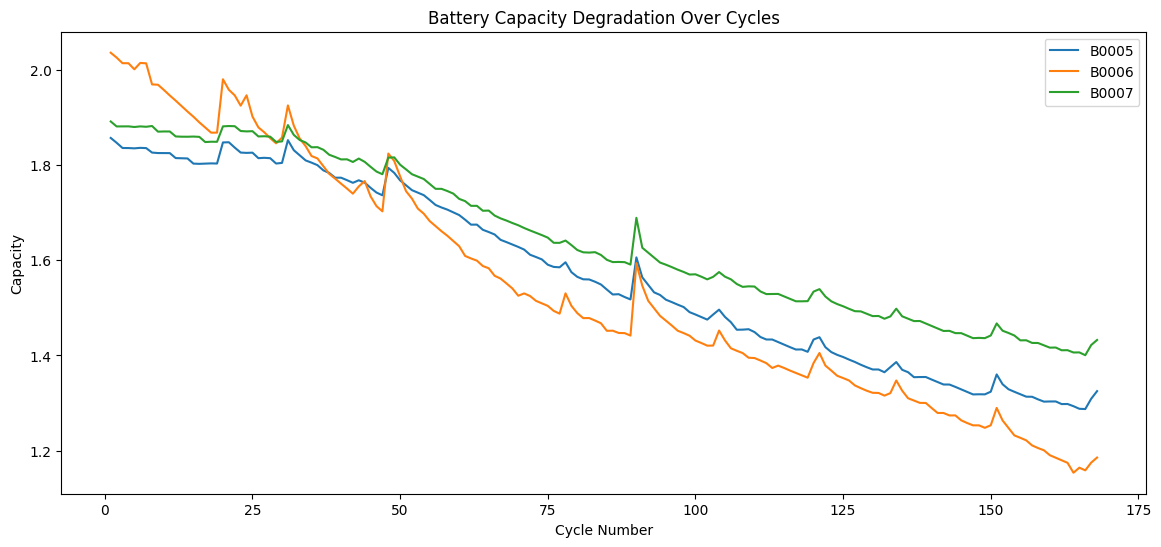

In [9]:
# Plot capacity degradation for sample batteries
plt.figure(figsize=(14, 6))
sample_batteries = df_final['battery_id'].unique()[:3]

for battery_id in sample_batteries:
    subset = df_final[df_final['battery_id'] == battery_id]
    plt.plot(subset['cycle'], subset['capacity_last'], label=f'{battery_id}')

plt.xlabel('Cycle Number')
plt.ylabel('Capacity')
plt.title('Battery Capacity Degradation Over Cycles')
plt.legend()
plt.show()

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


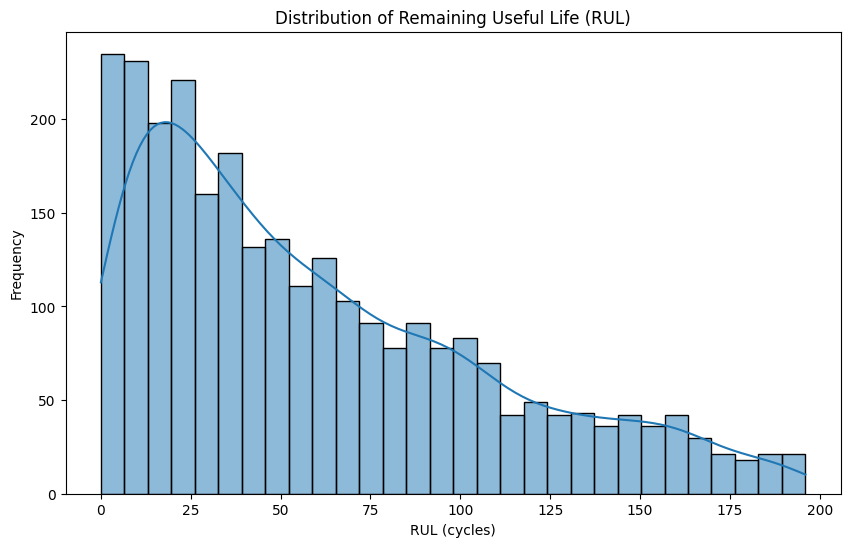

In [10]:
# Plot RUL distribution
plt.figure(figsize=(10, 6))
sns.histplot(df_final['rul'], bins=30, kde=True)
plt.title('Distribution of Remaining Useful Life (RUL)')
plt.xlabel('RUL (cycles)')
plt.ylabel('Frequency')
plt.show()

/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


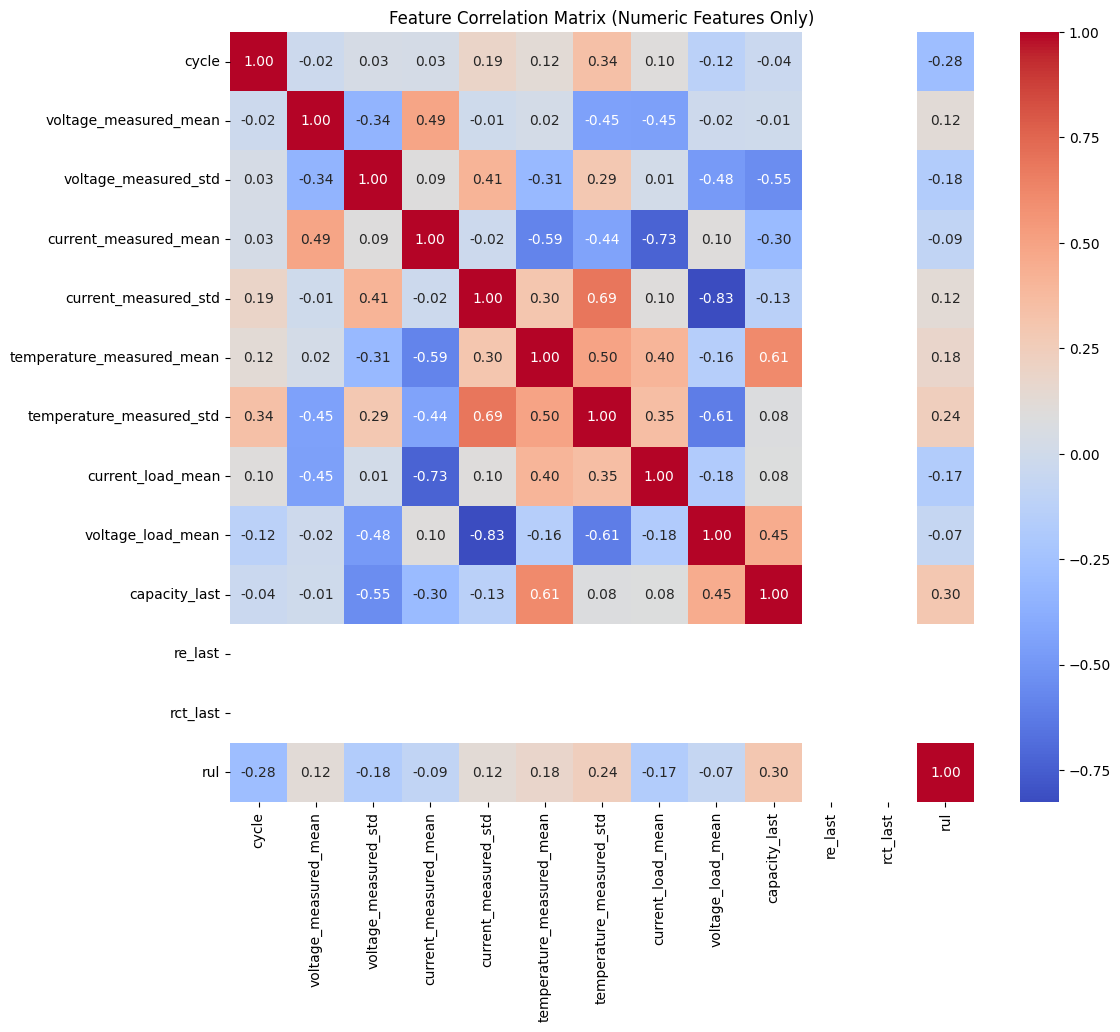

In [11]:
# Correlation matrix - fixed version
plt.figure(figsize=(12, 10))

# Select only numeric columns for correlation
numeric_cols = df_final.select_dtypes(include=[np.number]).columns
corr_matrix = df_final[numeric_cols].corr()

# Plot heatmap
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Feature Correlation Matrix (Numeric Features Only)')
plt.show()

In [12]:
# Select features and target
features = [col for col in df_final.columns 
            if col not in ['battery_id', 'cycle', 'rul'] and 
            not col.startswith('level_')]
target = 'rul'

# Handle missing values
missing_percent = df_final[features].isnull().mean()
print("Missing values percentage:\n", missing_percent.sort_values(ascending=False))

# Drop columns with 100% missing values
features = [f for f in features if missing_percent[f] < 1.0]

# Impute remaining missing values
imputer = SimpleImputer(strategy='median')
df_final[features] = imputer.fit_transform(df_final[features])

# Normalize features
scaler = StandardScaler()
df_final[features] = scaler.fit_transform(df_final[features])

print("\nFinal features used:", features)

Missing values percentage:
 re_last                      1.0
rct_last                     1.0
voltage_measured_mean        0.0
current_measured_mean        0.0
voltage_measured_std         0.0
current_measured_std         0.0
temperature_measured_mean    0.0
current_load_mean            0.0
temperature_measured_std     0.0
capacity_last                0.0
voltage_load_mean            0.0
dtype: float64

Final features used: ['voltage_measured_mean', 'voltage_measured_std', 'current_measured_mean', 'current_measured_std', 'temperature_measured_mean', 'temperature_measured_std', 'current_load_mean', 'voltage_load_mean', 'capacity_last']


In [13]:
# Train-test split by battery (leave some batteries out for testing)
batteries = df_final['battery_id'].unique()
train_batteries, test_batteries = train_test_split(batteries, test_size=0.2, random_state=42)

train_data = df_final[df_final['battery_id'].isin(train_batteries)]
test_data = df_final[df_final['battery_id'].isin(test_batteries)]

X_train = train_data[features]
y_train = train_data[target]
X_test = test_data[features]
y_test = test_data[target]

print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")

Train shape: (2340, 9), Test shape: (429, 9)


In [14]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

# Initialize models
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(random_state=42, n_estimators=100),
    'XGBoost': XGBRegressor(random_state=42, n_estimators=100, objective='reg:squarederror')
}

# Train and evaluate models
results = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    
    mse = mean_squared_error(y_test, preds)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, preds)
    
    results[name] = {'MSE': mse, 'RMSE': rmse, 'R2': r2}
    print(f"{name}:")
    print(f"  MSE: {mse:.4f}")
    print(f"  RMSE: {rmse:.4f}")
    print(f"  R2: {r2:.4f}\n")

# Convert results to dataframe
results_df = pd.DataFrame(results).T
results_df.sort_values('R2', ascending=False)

Linear Regression:
  MSE: 1993.8816
  RMSE: 44.6529
  R2: -1.1102

Random Forest:
  MSE: 1111.9151
  RMSE: 33.3454
  R2: -0.1768

XGBoost:
  MSE: 1827.1943
  RMSE: 42.7457
  R2: -0.9338



,MSE,RMSE,R2
Random Forest,1111.915064,33.345390,-0.176770
XGBoost,1827.194322,42.745694,-0.933769
Linear Regression,1993.881642,44.652902,-1.110179


In [15]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Hyperparameter tuning for Random Forest
rf = RandomForestRegressor(random_state=42)

param_dist = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

random_search = RandomizedSearchCV(
    rf, 
    param_distributions=param_dist,
    n_iter=10, 
    cv=3, 
    scoring='neg_mean_squared_error',
    random_state=42, 
    n_jobs=-1
)

random_search.fit(X_train, y_train)

# Get best model
best_rf = random_search.best_estimator_
print("Best Random Forest parameters:", random_search.best_params_)

# Evaluate tuned model
preds = best_rf.predict(X_test)
mse = mean_squared_error(y_test, preds)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, preds)

print("\nTuned Random Forest Performance:")
print(f"  MSE: {mse:.4f}")
print(f"  RMSE: {rmse:.4f}")
print(f"  R2: {r2:.4f}")

Best Random Forest parameters: {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': 10}

Tuned Random Forest Performance:
  MSE: 1063.8886
  RMSE: 32.6173
  R2: -0.1259


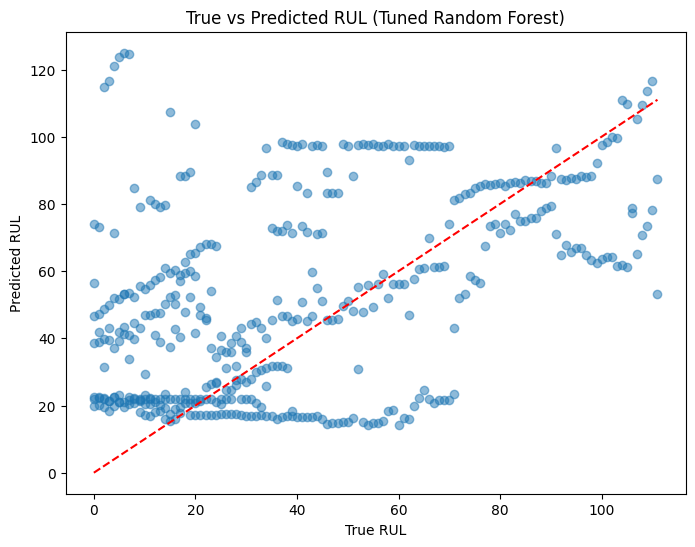

In [16]:
# Plot predicted vs true RUL
plt.figure(figsize=(8, 6))
plt.scatter(y_test, preds, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('True RUL')
plt.ylabel('Predicted RUL')
plt.title('True vs Predicted RUL (Tuned Random Forest)')
plt.show()

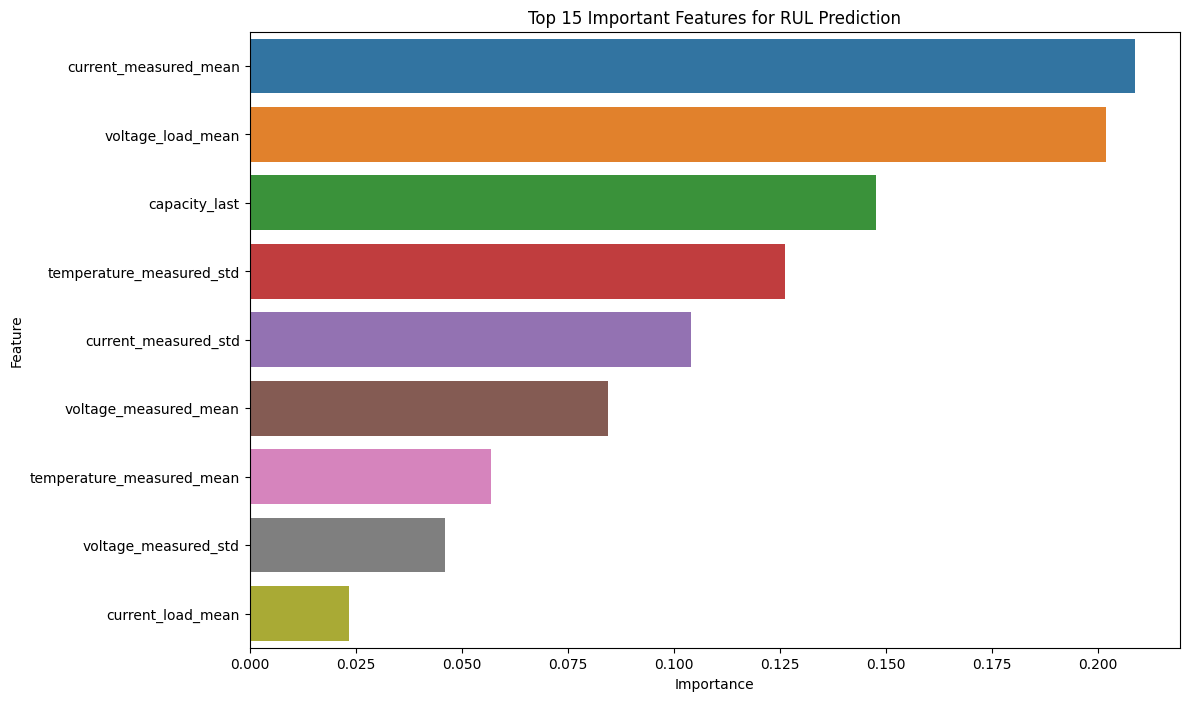

In [17]:
# Feature importance
feature_importance = pd.DataFrame({
    'Feature': features,
    'Importance': best_rf.feature_importances_
}).sort_values('Importance', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance.head(15))
plt.title('Top 15 Important Features for RUL Prediction')
plt.show()

In [18]:
# Train final model on all data
final_model = RandomForestRegressor(
    n_estimators=200,
    min_samples_split=5,
    min_samples_leaf=2,
    max_depth=20,
    random_state=42
)

final_model.fit(pd.concat([X_train, X_test]), pd.concat([y_train, y_test]))

# Save model and scaler
import joblib
joblib.dump(final_model, 'battery_rul_model.pkl')
joblib.dump(scaler, 'scaler.pkl')

print("Final model trained and saved successfully!")

Final model trained and saved successfully!


In [19]:
import joblib
import pandas as pd

def predict_rul_interactive():
    """
    Interactive function to predict RUL from user input
    """
    try:
        # Load the saved model and scaler
        model = joblib.load('battery_rul_model.pkl')
        scaler = joblib.load('scaler.pkl')
        
        # Get feature names from the model
        features = model.feature_names_in_
        
        print("\n⚡ Battery RUL Prediction System ⚡")
        print(f"Please enter values for the following {len(features)} features:")
        print("(Enter numeric values only, e.g., 4.2, 0.5, 25.0)")
        print("-"*50)
        
        # Collect user input for each feature
        input_data = {}
        for feature in features:
            while True:
                try:
                    value = float(input(f"{feature}: "))
                    input_data[feature] = value
                    break
                except ValueError:
                    print("Invalid input! Please enter a numeric value (e.g., 3.14)")
        
        # Create DataFrame from input
        new_data = pd.DataFrame([input_data])
        
        # Transform using saved scaler
        scaled_data = scaler.transform(new_data)
        
        # Make prediction
        rul_prediction = model.predict(scaled_data)[0]
        
        print("\n" + "="*50)
        print(f"🔋 Predicted Remaining Useful Life: {rul_prediction:.1f} cycles")
        print("="*50)
        return rul_prediction
    
    except FileNotFoundError:
        print("\n❌ Error: Model files not found. Please train the model first.")
        print("Make sure 'battery_rul_model.pkl' and 'scaler.pkl' exist in your directory.")
        return None
    except Exception as e:
        print(f"\n❌ An error occurred: {str(e)}")
        return None

# ==============================================
# ACTUALLY RUN THE PREDICTION SYSTEM
# ==============================================
if __name__ == "__main__":
    print("Starting Battery RUL Prediction...")
    predict_rul_interactive()

Starting Battery RUL Prediction...

⚡ Battery RUL Prediction System ⚡
Please enter values for the following 9 features:
(Enter numeric values only, e.g., 4.2, 0.5, 25.0)
--------------------------------------------------

❌ An error occurred: raw_input was called, but this frontend does not support input requests.
